# 0. Import packages + Setup

In [1]:
!pip install nitime

In [2]:
!pip install keras_applications

In [3]:
!pip install tqdm

In [4]:
import nilearn
import os
import tqdm
from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
import pandas as pd
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import CanICA
from nilearn.decomposition import DictLearning
from nilearn.regions import RegionExtractor
from nilearn.input_data import NiftiMasker
import pandas as pd
import matplotlib.pyplot as plt
import pywt 
from skimage.transform import resize
from tensorflow import keras
import keras_applications as ka
import tensorflow as tf
from glob import glob
import seaborn as sns
from nilearn import image as nimg
from nilearn.regions import connected_label_regions
from nilearn import plotting as nplot
from nilearn import input_data
import scipy
from scipy import signal
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score

# 1. **Loading the data and cleaning confounders**

In [5]:
ls /home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/

rois/  TOC/


In [6]:
participants_path = '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/Class.csv'
participants = pd.read_csv(participants_path, sep = ';')
participants.head()

participant_id  Group
0        sub-000      1
1        sub-001      1
2        sub-002      0
3        sub-003      1
4        sub-004      1

In [7]:
participants[(participants.Group == 1)].shape[0]

15

In [8]:
participants[(participants.Group == 0)].shape[0]

15

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Group', ylabel='Density'>

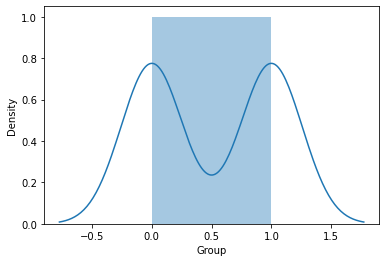

In [9]:
sns.distplot(participants.Group)

In [10]:
P = participants.loc[participants['Group'].isin([1])].index
P

Int64Index([0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 20], dtype='int64')

In [11]:
C = participants.loc[participants['Group'].isin([0])].index
C

Int64Index([2, 5, 7, 12, 15, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype='int64')

In [12]:
for _,_,arquivo in os.walk('/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/'):
    if arquivo != []:
        print(arquivo)
        break

['sub-046_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv', 'sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-026_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv', 'sub-019_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv', 'sub-002_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-011_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv', 'sub-047_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-031_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv', 

In [13]:
new_arq = [] 
aux = 0
for arq in arquivo:
    if arq[-7:] == ".nii.gz":
        new_arq.append(arq)
        aux += 1

In [14]:
print(aux)
print(new_arq)

30
['sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-002_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-011_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-047_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-017_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-010_task-TOCCHOQUE_acq-RSEPI51F24mmSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-016_task-TOCCHOQUE_acq-RSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-006_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.g

In [15]:
rest_files = ['/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/%s' % sub for sub in new_arq]
rest_files

['/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-002_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-011_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-047_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-017_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/home/neuro/workshop/Do

In [16]:
file_name_conf = []
for file_name_ in new_arq:
    file_name_conf.append("".join((file_name_[:-57], "_desc-confounds_timeseries.tsv")))

In [17]:
print(len(file_name_conf))
file_name_conf

30


['sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-002_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-011_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-047_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-017_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-010_task-TOCCHOQUE_acq-RSEPI51F24mmSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-016_task-TOCCHOQUE_acq-RSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-006_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-030_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-020_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 'sub-00

In [18]:
confounds_files = ['/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/%s' % sub for sub in file_name_conf]
confounds_files

['/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-000_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-002_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-011_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-047_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-017_task-TOCCHOQUE_acq-WIPRSEPINOSOFT41FSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv',
 '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/TOC/sub-010_task-TOCCHOQUE_acq-RSEPI51F24mmSENSE_rec-FEEPI_run-1_desc-confounds_timeseries.tsv

My study

In [19]:
confound_df = pd.read_table(confounds_files[0])
confound_df

global_signal  global_signal_derivative1  global_signal_power2  \
0    326880.780918                        NaN          1.068510e+11   
1    326735.142516                -145.638402          1.067559e+11   
2    326709.509024                 -25.633492          1.067391e+11   
3    326385.070364                -324.438660          1.065272e+11   
4    327007.368558                 622.298194          1.069338e+11   
..             ...                        ...                   ...   
125  329958.874088                 201.902976          1.088729e+11   
126  329782.919575                -175.954514          1.087568e+11   
127  329403.379252                -379.540323          1.085066e+11   
128  329394.636565                  -8.742687          1.085008e+11   
129  329353.140342                 -41.496223          1.084735e+11   

     global_signal_derivative1_power2            csf  csf_derivative1  \
0                                 NaN  679548.725345              NaN   
1                        21210.544268  676322.100831     -3226.624514   
2                          657.075890  678048.816979      1726.716148   
3                       105260.443982  674240.351302     -3808.465677   
4                       387255.042225  677470.555644      3230.204343   
..                                ...            ...              ...   
125                      40764.811648  680873.874797     -1499.336561   
126                      30959.990922  681625.720736       751.845939   
127                     144050.856720  680870.632421      -755.088315   
128                         76.434575  680597.873072      -272.759349   
129                       1721.936501  681080.597171       482.724098   

     csf_derivative1_power2    csf_power2   white_matter  \
0                       NaN  4.617865e+11  328091.893713   
1              1.041111e+07  4.574116e+11  327897.431963   
2              2.981549e+06  4.597502e+11  328425.267807   
3              1.450441e+07  4.546001e+11  327893.329065   
4              1.043422e+07  4.589664e+11  328215.115411   
..                      ...           ...            ...   
125            2.248010e+06  4.635892e+11  330145.529679   
126            5.652723e+05  4.646136e+11  329972.092173   
127            5.701584e+05  4.635848e+11  329873.867577   
128            7.439766e+04  4.632135e+11  330387.213714   
129            2.330226e+05  4.638708e+11  330012.596460   

     white_matter_derivative1  ...  rot_y_power2     rot_z  rot_z_derivative1  \
0                         NaN  ...  5.360244e-08  0.000173                NaN   
1                 -194.461750  ...  0.000000e+00  0.000443           0.000271   
2                  527.835845  ...  0.000000e+00  0.000000          -0.000443   
3                 -531.938743  ...  0.000000e+00  0.000000           0.000000   
4                  321.786346  ...  0.000000e+00 -0.000068          -0.000068   
..                        ...  ...           ...       ...                ...   
125                -20.379182  ...  7.777071e-08  0.001315           0.000222   
126               -173.437506  ...  7.777071e-08  0.001241          -0.000074   
127                -98.224596  ...  3.425572e-08  0.001235          -0.000006   
128                513.346136  ...  8.942520e-09  0.001381           0.000146   
129               -374.617253  ...  4.386679e-08  0.001037          -0.000344   

     rot_z_derivative1_power2  rot_z_power2  motion_outlier00  \
0                         NaN  2.979905e-08               0.0   
1                7.324817e-08  1.964865e-07               0.0   
2                1.964865e-07  0.000000e+00               0.0   
3                0.000000e+00  0.000000e+00               0.0   
4                4.579202e-09  4.579202e-09               0.0   
..                        ...           ...               ...   
125              4.918193e-08  1.730409e-06               0.0   
126              5.480441e-09  1.541124e-06               0.0

In [20]:
# Select confounds
confound_vars = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z',
                 'global_signal',
                 'csf', 'white_matter']

In [21]:
# Get derivative column names
derivative_columns = ['{}_derivative1'.format(c) for c
                     in confound_vars]

print(derivative_columns)

['trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


In [22]:
final_confounds = confound_vars + derivative_columns
print(final_confounds)

['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal', 'csf', 'white_matter', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


In [23]:
confound_df = confound_df[final_confounds]
confound_df

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  \
0   -0.015708  0.065918  0.100334 -0.003078 -0.000232  0.000173   
1   -0.018652  0.063635  0.075008 -0.002639 -0.000000  0.000443   
2   -0.018632  0.063627  0.078141 -0.003069 -0.000000  0.000000   
3   -0.018632  0.079421  0.067882 -0.002222 -0.000000  0.000000   
4   -0.018630  0.054708  0.059472 -0.002196 -0.000000 -0.000068   
..        ...       ...       ...       ...       ...       ...   
125  0.074501 -0.559159 -0.156482  0.005546 -0.000279  0.001315   
126  0.079102 -0.562798 -0.161886  0.005435 -0.000279  0.001241   
127  0.080701 -0.559171 -0.170982  0.005442 -0.000185  0.001235   
128  0.082974 -0.545962 -0.162486  0.005863 -0.000095  0.001381   
129  0.093873 -0.570588 -0.182468  0.005822 -0.000209  0.001037   

     global_signal            csf   white_matter  trans_x_derivative1  \
0    326880.780918  679548.725345  328091.893713                  NaN   
1    326735.142516  676322.100831  327897.431963            -0.002944   
2    326709.509024  678048.816979  328425.267807             0.000020   
3    326385.070364  674240.351302  327893.329065             0.000000   
4    327007.368558  677470.555644  328215.115411             0.000001   
..             ...            ...            ...                  ...   
125  329958.874088  680873.874797  330145.529679             0.001391   
126  329782.919575  681625.720736  329972.092173             0.004600   
127  329403.379252  680870.632421  329873.867577             0.001599   
128  329394.636565  680597.873072  330387.213714             0.002274   
129  329353.140342  681080.597171  330012.596460             0.010899   

     trans_y_derivative1  trans_z_derivative1  rot_x_derivative1  \
0                    NaN                  NaN                NaN   
1              -0.002282            -0.025326           0.000439   
2              -0.000009             0.003133          -0.000431   
3               0.015795            -0.010259           0.000847   
4              -0.024713            -0.008410           0.000027   
..                   ...                  ...                ...   
125            -0.005906            -0.008202          -0.000476   
126            -0.003639            -0.005404          -0.000112   
127             0.003627            -0.009096           0.000008   
128             0.013209             0.008496           0.000421   
129            -0.024626            -0.019982          -0.000042   

     rot_y_derivative1  rot_z_derivative1  global_signal_derivative1  \
0                  NaN                NaN                        NaN   
1             0.000232           0.000271                -145.638402   
2             0.000000          -0.000443                 -25.633492   
3             0.000000           0.000000                -324.438660   
4             0.000000          -0.000068                 622.298194   
..                 ...                ...                        ...   
125          -0.000057           0.000222                 201.902976   
126           0.000000          -0.000074                -175.954514   
127           0.000094          -0.000006                -379.540323   
128           0.000091           0.000146                  -8.742687   
129          -0.000115          -0.000344                 -41.496223   

     csf_derivative1  white_matter_derivative1  
0                NaN                       NaN  
1       -3226.624514               -194.461750  
2        1726.716148                527.835845  
3       -3808.465677               -531.938743  
4        3230.204343                321.786346  
..               ...                       ...  
125     -1499.336561                -20.379182  
126       751.845939               -173.437506  
127      -755.088315                -98.224596  
128      -272.759349                513.346136  
129       482.724098               -374.617253  

[130 rows x 18 columns]

In [24]:
raw_func_img = nimg.load_img(rest_files[0])
raw_func_img.shape

(97, 115, 97, 130)

In [25]:
func_img = raw_func_img.slicer[:,:,:,4:]
func_img.shape

(97, 115, 97, 126)

In [26]:
drop_confound_df = confound_df.loc[4:]
print(drop_confound_df.shape)
drop_confound_df

(126, 18)


trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  \
4   -0.018630  0.054708  0.059472 -0.002196 -0.000000 -0.000068   
5   -0.018632  0.038288  0.095423 -0.002355 -0.000000  0.000000   
6   -0.018625  0.065191  0.056485 -0.002530 -0.000083  0.000000   
7   -0.018635  0.062166  0.054111 -0.001863 -0.000000  0.000199   
8   -0.018599  0.052041  0.042093 -0.001863 -0.000084  0.000092   
..        ...       ...       ...       ...       ...       ...   
125  0.074501 -0.559159 -0.156482  0.005546 -0.000279  0.001315   
126  0.079102 -0.562798 -0.161886  0.005435 -0.000279  0.001241   
127  0.080701 -0.559171 -0.170982  0.005442 -0.000185  0.001235   
128  0.082974 -0.545962 -0.162486  0.005863 -0.000095  0.001381   
129  0.093873 -0.570588 -0.182468  0.005822 -0.000209  0.001037   

     global_signal            csf   white_matter  trans_x_derivative1  \
4    327007.368558  677470.555644  328215.115411             0.000001   
5    327046.102528  676568.982230  328054.614582            -0.000001   
6    326617.680055  674453.985955  327693.501373             0.000006   
7    327080.673069  674929.062500  327998.599474            -0.000010   
8    327217.207315  674732.745884  328045.126637             0.000036   
..             ...            ...            ...                  ...   
125  329958.874088  680873.874797  330145.529679             0.001391   
126  329782.919575  681625.720736  329972.092173             0.004600   
127  329403.379252  680870.632421  329873.867577             0.001599   
128  329394.636565  680597.873072  330387.213714             0.002274   
129  329353.140342  681080.597171  330012.596460             0.010899   

     trans_y_derivative1  trans_z_derivative1  rot_x_derivative1  \
4              -0.024713            -0.008410           0.000027   
5              -0.016420             0.035952          -0.000159   
6               0.026902            -0.038939          -0.000175   
7              -0.003024            -0.002374           0.000667   
8              -0.010125            -0.012018           0.000000   
..                   ...                  ...                ...   
125            -0.005906            -0.008202          -0.000476   
126            -0.003639            -0.005404          -0.000112   
127             0.003627            -0.009096           0.000008   
128             0.013209             0.008496           0.000421   
129            -0.024626            -0.019982          -0.000042   

     rot_y_derivative1  rot_z_derivative1  global_signal_derivative1  \
4             0.000000          -0.000068                 622.298194   
5             0.000000           0.000068                  38.733970   
6            -0.000083           0.000000                -428.422473   
7             0.000083           0.000199                 462.993014   
8            -0.000084          -0.000107                 136.534246   
..                 ...                ...                        ...   
125          -0.000057           0.000222                 201.902976   
126           0.000000          -0.000074                -175.954514   
127           0.000094          -0.000006                -379.540323   
128           0.000091           0.000146                  -8.742687   
129          -0.000115          -0.000344                 -41.496223   

     csf_derivative1  white_matter_derivative1  
4        3230.204343                321.786346  
5        -901.573414               -160.500829  
6       -2114.996275               -361.113209  
7         475.076545                305.098101  
8        -196.316616                 46.527162  
..               ...                       ...  
125     -1499.336561                -20.379182  
126       751.845939               -173.437506  
127      -755.088315                -98.224596  
128      -272.759349                513.346136  
129       482.724098               -374.617253  

[126 rows x 18 columns]

In [27]:
confounds_matrix = drop_confound_df.values
confounds_matrix.shape

(126, 18)

# 2. Extracting times series to build a functional connectome

1. Visual
2. Somatosensory
3. Dorsal Attention
4. Ventral Attention
5. Limbic
6. Frontoparietal
7. Default

In [28]:
parcel_dir = '/home/neuro/workshop/Doutorado_USP/0.Projeto_preliminar/Dataset/rois/'
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)

In [29]:
atlas_yeo_2011.keys()

dict_keys(['description', 'thin_7', 'thick_7', 'thin_17', 'thick_17', 'colors_7', 'colors_17', 'anat'])

In [30]:
atlas_yeo = atlas_yeo_2011['thick_7']

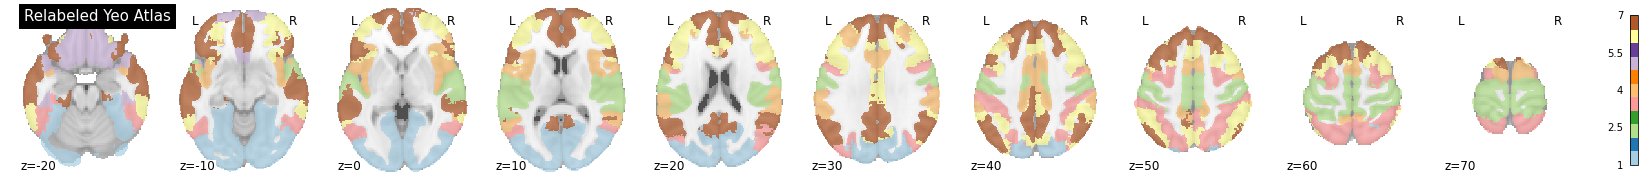

In [31]:
nplot.plot_roi(atlas_yeo,
               cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
               display_mode='z',
               colorbar=True,
               cmap='Paired',
               title='Relabeled Yeo Atlas')

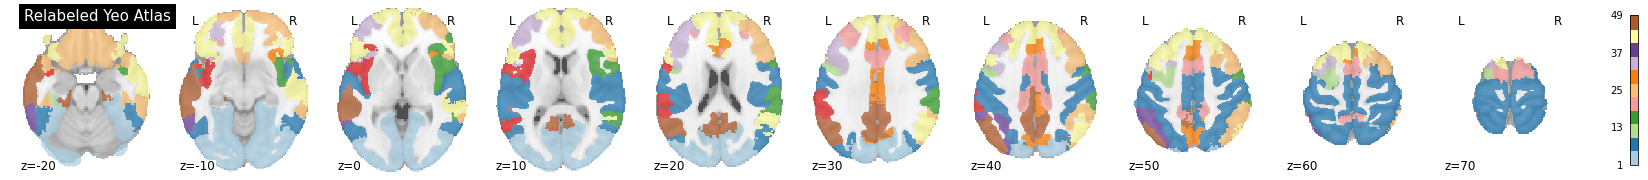

In [32]:
region_labels = connected_label_regions(atlas_yeo)
nplot.plot_roi(region_labels,
               cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
               display_mode='z',
               colorbar=True,
               cmap='Paired',
               title='Relabeled Yeo Atlas')

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



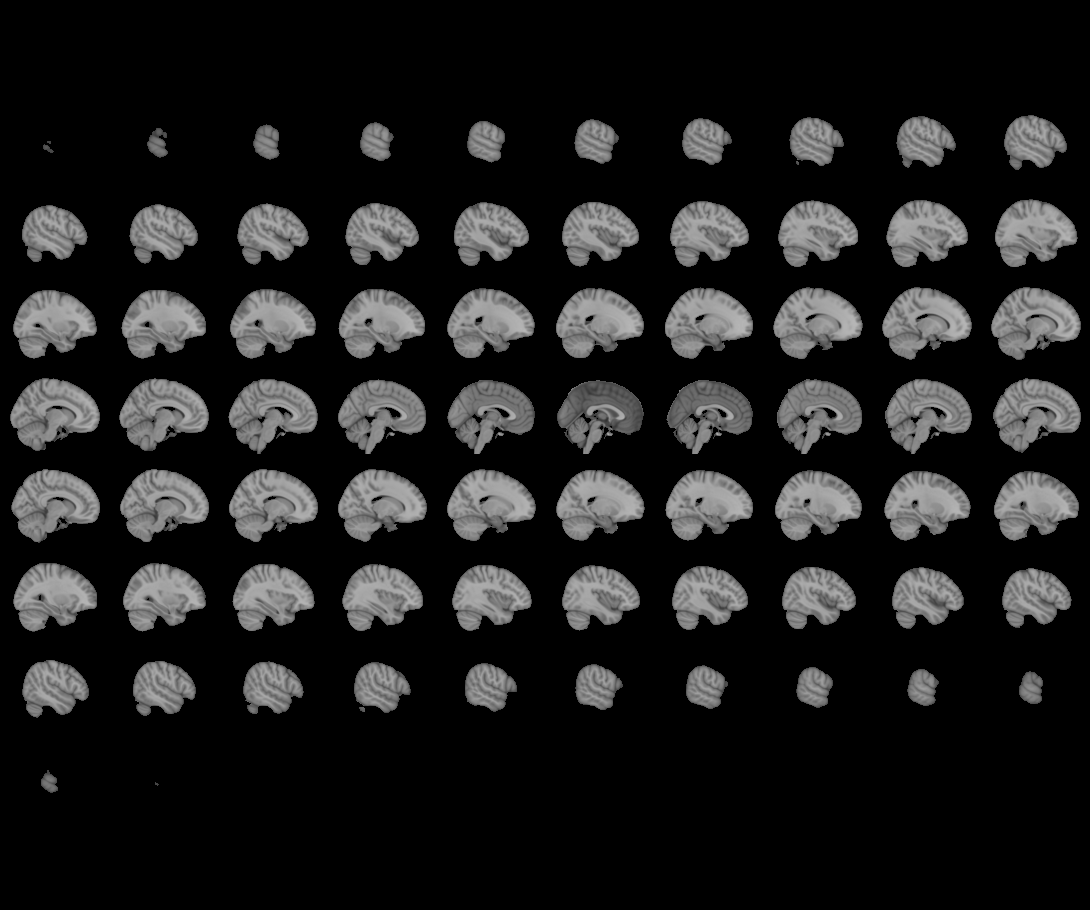
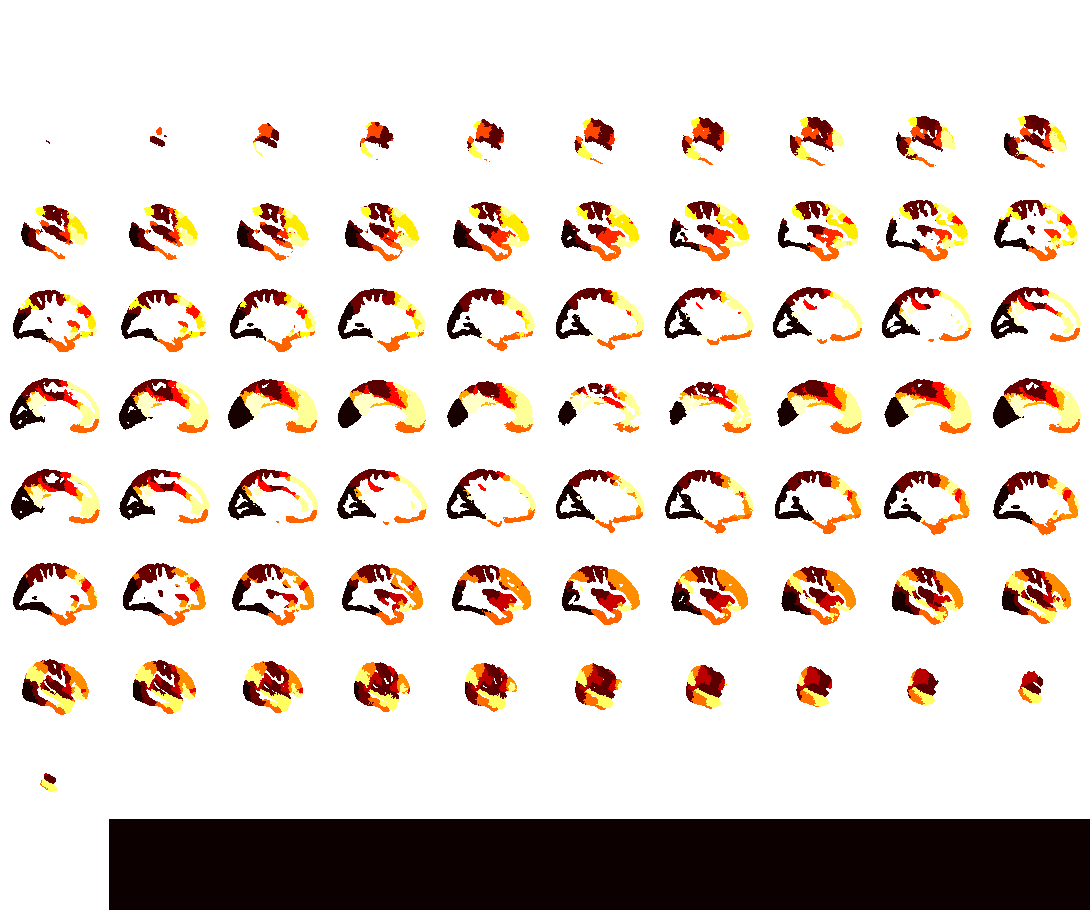

In [33]:
plotting.view_img(region_labels, draw_cross=False,colorbar=True)

In [34]:
atlas_labels = np.unique(region_labels.get_fdata().astype(int))
NUM_LABELS = len(atlas_labels)
print(NUM_LABELS)

50


In [35]:
print("Size of functional image:", func_img.shape)
print("Size of atlas image:", region_labels.shape)

resampled_yeo = nimg.resample_to_img(region_labels, func_img, interpolation = 'nearest')

Size of functional image: (97, 115, 97, 126)
Size of atlas image: (256, 256, 256)


Size of atlas image: (97, 115, 97)


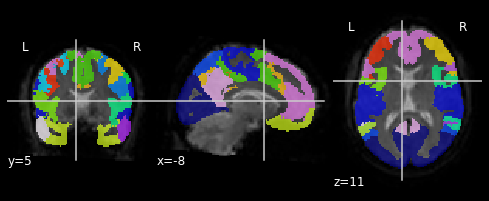

In [36]:
print("Size of atlas image:", resampled_yeo.shape)
nplot.plot_roi(resampled_yeo, func_img.slicer[:, :, :, 54])

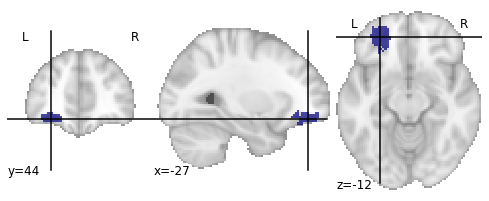

In [37]:
roi_mask = nimg.math_img('a == 36', a=resampled_yeo)  
nplot.plot_roi(roi_mask)

In [38]:
masker = input_data.NiftiLabelsMasker(labels_img=resampled_yeo,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

In [39]:
def extract_confounds(confound_tsv,confound_vars,dt=True):
    
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confound_vars                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    if dt:    
        dt_names = ['{}_derivative1'.format(c) for c in confound_vars]
        confound_vars = confound_vars + dt_names
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_table(confound_tsv)
    confound_df = confound_df[confound_vars]
    
 
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat

In [40]:
trs_drop = 4
stack = []
for i in range(0,len(rest_files)):
    raw_func_img = nimg.load_img(rest_files[i])
    func_img = raw_func_img.slicer[:,:,:,trs_drop:]
    num_timepoints = func_img.shape[3]
    final_signal = np.zeros((num_timepoints, NUM_LABELS))
    confounds = extract_confounds(confounds_files[i],confound_vars)
    confounds = confounds[trs_drop:,:] 
    time_series = masker.fit_transform(func_img,confounds)
    regions_kept = np.array(masker.labels_)
    final_signal[:, regions_kept] = time_series
    df = pd.DataFrame(final_signal, columns =list(range(0,len(final_signal[0,:]))), dtype = float).transpose()
    stack.append(df)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(97, 115, 97),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(97, 115, 97),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(97, 115, 97),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(97, 115, 97),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,  

In [41]:
for element in range(0,len(stack)):
    print(stack[element].T.shape[0])

126
126
126
126
126
96
126
126
126
126
126
126
126
126
126
126
126
126
96
96
126
126
126
126
126
126
126
126
126
126


In [42]:
for element in range(0,len(stack)):
    stack[element] = (stack[element].iloc[:, :96]).T

In [43]:
for element in range(0,len(stack)):
    print(stack[element].shape[0])

96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96


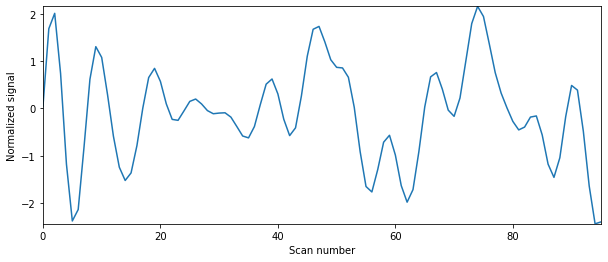

In [44]:
fig = plt.figure(figsize=(10, 4))
plt.plot(stack[0].loc[:,1])
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.autoscale(tight=True) 
plt.show()

In [45]:
np.array(stack[0].values).shape

(96, 50)

In [46]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([np.array(stack[0].values)])[0]
correlation_matrix.shape

(50, 50)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:112: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordered_linkage = optimal_leaf_ordering(linkage_matrix, mat)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:17: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_

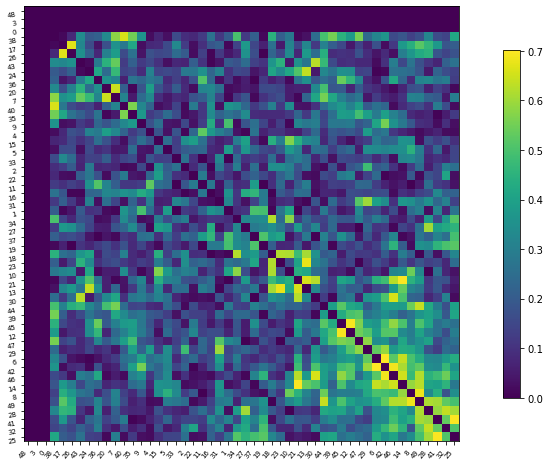

In [47]:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(np.abs(correlation_matrix), figure=(10, 8), 
                     labels=range(stack[0].values.shape[-1]), cmap='viridis', reorder=True)


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



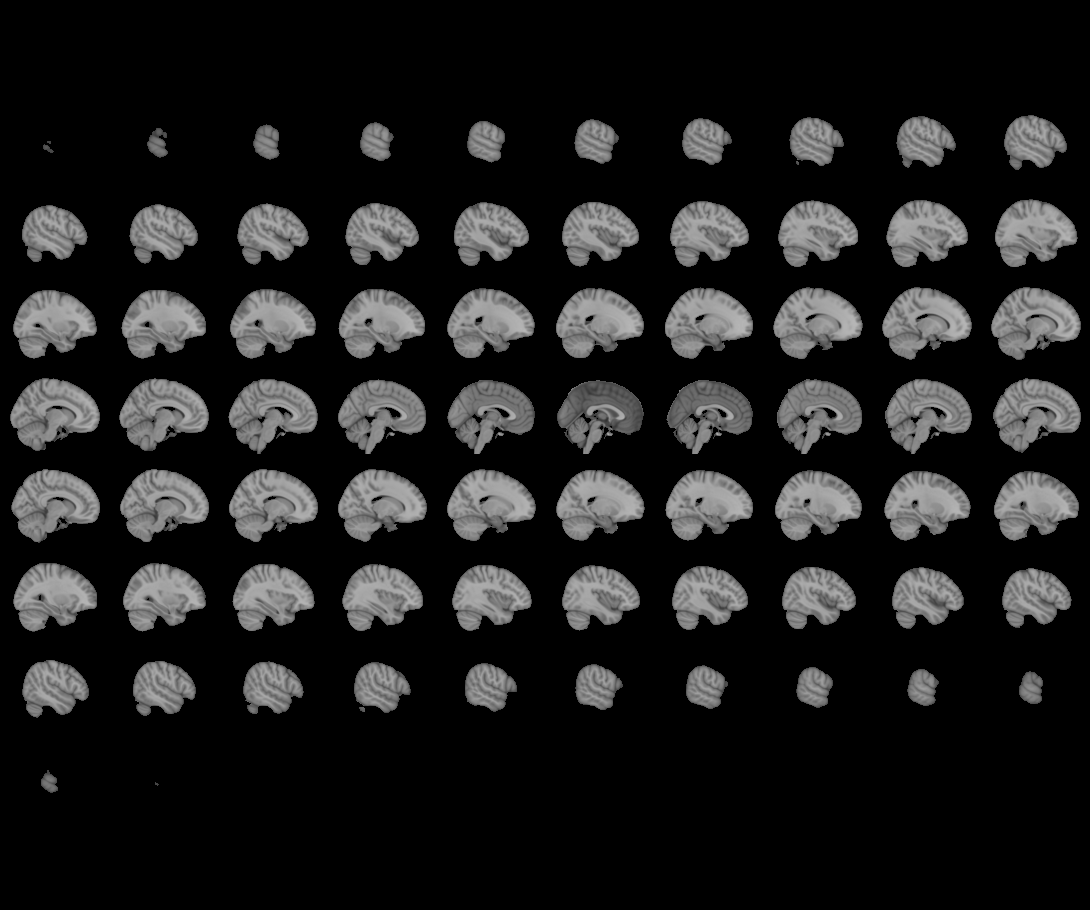
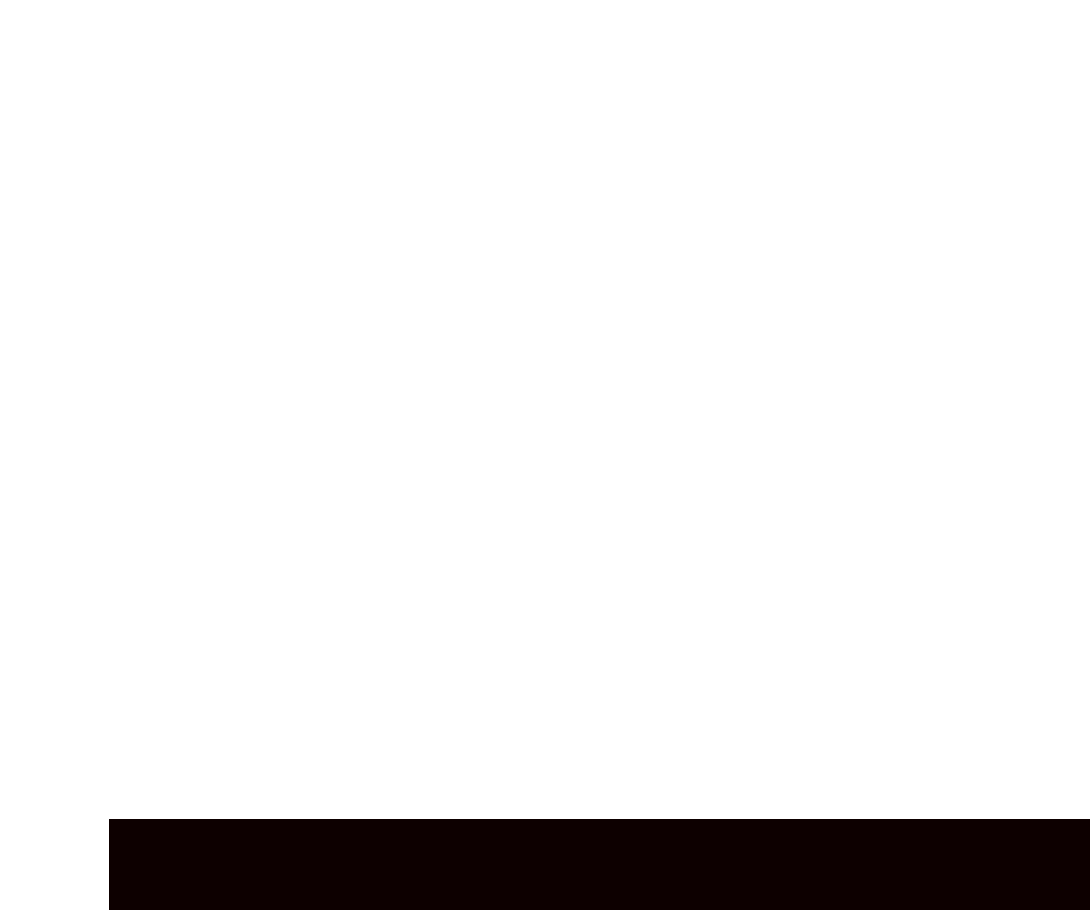

In [48]:
roi_mask = nimg.math_img('a == 45', a=region_labels)  
plotting.view_img(roi_mask, draw_cross=False,colorbar=True)

In [49]:
ctrl_subjects = []
for i in range(0,len(stack)):
    if i in C:
        ctrl_subjects.append(stack[i])
ctrl_subjects

[     0         1         2    3         4         5         6         7   \
 0   0.0 -0.096287  0.028395  0.0  0.199824 -0.530172 -0.422260  0.310536   
 1   0.0  0.436365  0.591116  0.0  0.007234  0.712187 -1.017813  1.324079   
 2   0.0  0.767938  0.621544  0.0  0.052245  1.001621 -1.637478  1.686675   
 3   0.0  0.694922  0.012421  0.0  0.259761  0.262454 -2.022158  1.122750   
 4   0.0  0.200610 -0.807275  0.0  0.323701 -0.668715 -1.812778 -0.026301   
 ..  ...       ...       ...  ...       ...       ...       ...       ...   
 91  0.0 -1.027926 -0.117805  0.0 -1.615666 -0.796995  0.003631  0.173236   
 92  0.0 -0.368160  0.820314  0.0 -0.667002 -1.565658  0.471527  0.705001   
 93  0.0  0.810058  1.687005  0.0  0.806762 -1.602208  0.673776  1.226508   
 94  0.0  1.672305  2.022576  0.0  2.034929 -0.742012  0.447480  1.215490   
 95  0.0  1.576596  1.654569  0.0  2.199961  0.592602 -0.000477  0.528710   
 
           8         9   ...        40        41        42        43      

In [50]:
patient_subjects = []
for i in range(0,len(stack)):
    if i in P:
        patient_subjects.append(stack[i])
patient_subjects   

[     0         1         2    3         4         5         6         7   \
 0   0.0  0.042303 -0.217960  0.0 -0.332099  0.164063 -0.152385 -0.075875   
 1   0.0  1.687130  0.683660  0.0 -0.940840 -0.161848 -0.260309 -0.039548   
 2   0.0  2.011667  0.784795  0.0 -0.975967 -0.252805 -0.312603 -0.211930   
 3   0.0  0.741915 -0.093402  0.0 -0.332016  0.075725 -0.301639 -0.581645   
 4   0.0 -1.176585 -1.335013  0.0  0.523792  0.828671 -0.273088 -0.927594   
 ..  ...       ...       ...  ...       ...       ...       ...       ...   
 91  0.0  0.388313  0.097686  0.0 -2.111613 -0.415293 -0.340451 -0.066442   
 92  0.0 -0.480286 -0.497587  0.0 -2.000492  0.246413 -0.302636 -0.601612   
 93  0.0 -1.638094 -0.662473  0.0 -0.591800  0.732572 -0.096250 -1.332889   
 94  0.0 -2.438438 -0.378310  0.0  1.195057  0.986412  0.125019 -1.953937   
 95  0.0 -2.398730  0.271776  0.0  2.282708  0.955974  0.192088 -2.203802   
 
           8         9   ...        40        41        42        43      

In [51]:
ctrl_correlation_matrix = correlation_measure.fit_transform([np.array(ctrl_subjects[0].values)])[0]
patient_correlation_matrix = correlation_measure.fit_transform([np.array(patient_subjects[0].values)])[0]

In [52]:
ctrl_correlation_matrix.shape

(50, 50)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:112: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordered_linkage = optimal_leaf_ordering(linkage_matrix, mat)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:17: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_

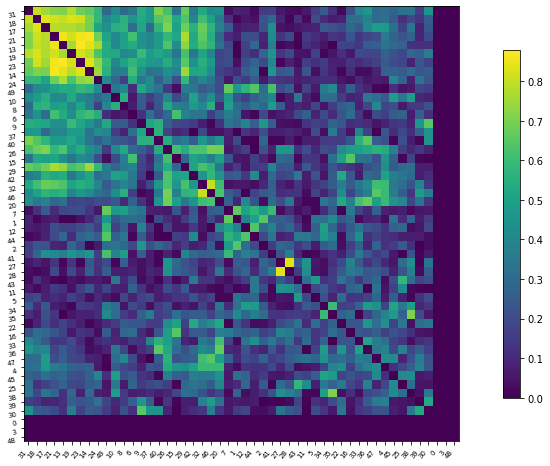

In [53]:
np.fill_diagonal(ctrl_correlation_matrix, 0)

plotting.plot_matrix(np.abs(ctrl_correlation_matrix), figure=(10, 8), 
                     labels=range(ctrl_subjects[0].values.shape[-1]), cmap='viridis', reorder=True)

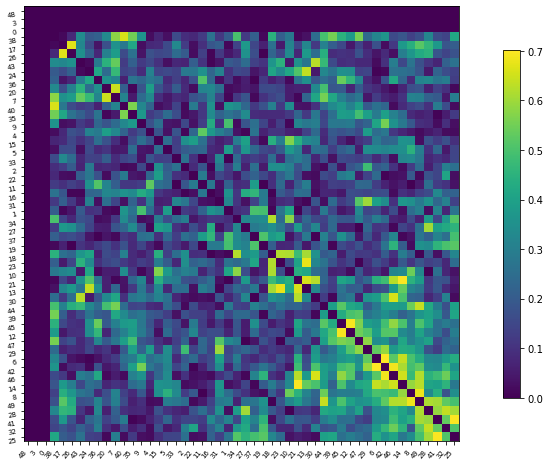

In [54]:
np.fill_diagonal(patient_correlation_matrix, 0)

plotting.plot_matrix(np.abs(patient_correlation_matrix), figure=(10, 8), 
                     labels=range(patient_subjects[0].values.shape[-1]), cmap='viridis', reorder=True)

My study

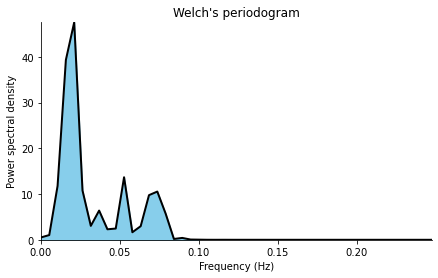

In [55]:
sf = 0.5
int_f = 0.021
freqs, psd = signal.welch(stack[0].loc[:,1], sf, window = scipy.signal.windows.hamming(int(2/int_f), sym=True), noverlap = int(2/int_f)//2)

# Define delta lower and upper limits
low, high = 0.0, 0.1
#low, high = 0.0, 0.25

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.title("Welch's periodogram")
plt.autoscale(tight=True) 
sns.despine()

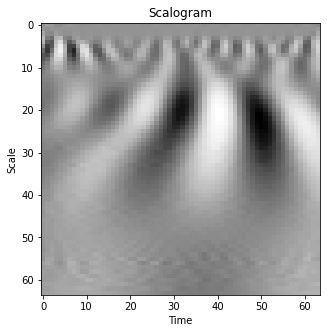

In [56]:
n_scales = 64
rescale_size = 64
scales = np.arange(1, n_scales + 1) 
wavelet_name = "morl"

coeffs, freqs = pywt.cwt(np.array(stack[0].loc[:,1]), scales, wavelet_name)
rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.imshow(rescale_coeffs, cmap = 'Greys', aspect = 'auto')
ax.set_title('Scalogram')
ax.set_ylabel('Scale')
ax.set_xlabel('Time')
plt.show()

# 3. Extract features

In [57]:
trs_drop = 4
all_features = []
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
for i in range(0,len(rest_files)):
    correlation_matrix = correlation_measure.fit_transform([np.array(stack[i].values)])[0]
    all_features.append(correlation_matrix)

In [58]:
all_features = np.array(all_features)

In [59]:
all_features.shape

(30, 1225)

Text(0, 0.5, 'subjects')

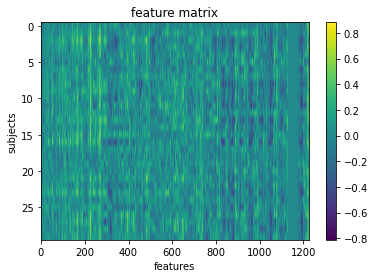

In [60]:
plt.imshow(all_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

In [61]:
participants

participant_id  Group
0         sub-000      1
1         sub-001      1
2         sub-002      0
3         sub-003      1
4         sub-004      1
5         sub-005      0
6         sub-006      1
7         sub-007      0
8         sub-008      1
9         sub-009      1
10        sub-010      1
11        sub-011      1
12        sub-012      0
13        sub-013      1
14        sub-014      1
15        sub-015      0
16        sub-016      1
17        sub-017      1
18        sub-018      1
19        sub-019      0
20        sub-020      1
21        sub-021      0
22        sub-026      0
23        sub-030      0
24        sub-031      0
25        sub-033      0
26        sub-040      0
27        sub-046      0
28        sub-047      0
29        sub-049      0

In [62]:
toc_class = participants['Group']

In [63]:
X_features = all_features
y_age = toc_class

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, 
                                                    y_age, 
                                                    test_size = 0.25, 
                                                    shuffle = True, 
                                                    stratify = toc_class,
                                                    random_state = 0)

print('training:', len(X_train),
     'testing:', len(X_val))

training: 22 testing: 8


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Group', ylabel='Density'>

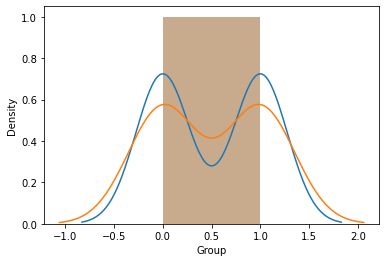

In [65]:
sns.distplot(y_train)
sns.distplot(y_val)

In [66]:
#X_train = preprocessing.normalize(X_train)
#X_val = preprocessing.normalize(X_val)

In [67]:
from sklearn.preprocessing import StandardScaler

#scaler = preprocessing.MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

In [68]:
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC(kernel='linear', C=1)
#RandomForestClassifier(random_state=0) #svm.SVC(kernel='rbf', C=10)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [69]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
acc = cross_val_score(clf, X_train, y_train, cv=10)
mae = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

for i in range(10):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i],-mae[i]))

Fold 0 -- Acc = 0.5, MAE = 0.5
Fold 1 -- Acc = 0.5, MAE = 0.5
Fold 2 -- Acc = 0.5, MAE = 0.5
Fold 3 -- Acc = 0.0, MAE = 1.0
Fold 4 -- Acc = 0.5, MAE = 0.5
Fold 5 -- Acc = 1.0, MAE = 0.0
Fold 6 -- Acc = 0.5, MAE = 0.5
Fold 7 -- Acc = 0.5, MAE = 0.5
Fold 8 -- Acc = 0.0, MAE = 1.0
Fold 9 -- Acc = 0.5, MAE = 0.5


In [70]:
y_pred = clf.predict(X_val) 

acc = clf.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

print('accuracy (R2) = ', acc)
print('MAE = ',mae)

accuracy (R2) =  0.5
MAE =  0.5


Text(0, 0.5, 'weight')

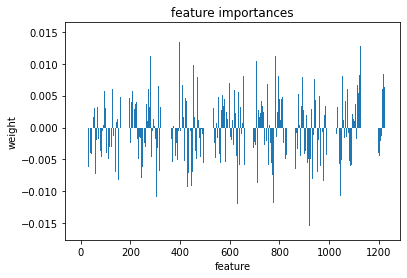

In [71]:
plt.bar(range(clf.coef_.shape[-1]),clf.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:17: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:25: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).height


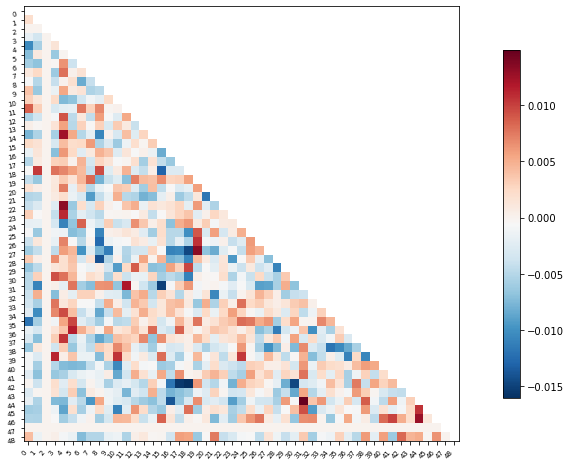

In [73]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(clf.coef_)[0]
feat_exp_matrix = feat_exp_matrix[1:,1:]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8),  
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

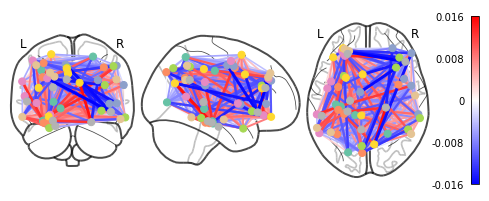

In [74]:
coords = plotting.find_parcellation_cut_coords(region_labels)#, background_label = 50)
coords.shape
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True)

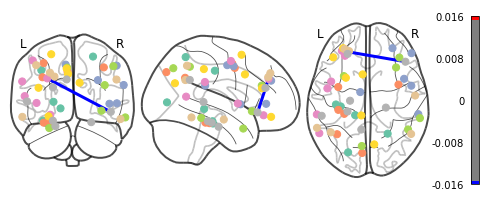

In [75]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.0155)

In [76]:
%matplotlib notebook
plotting.view_connectome(feat_exp_matrix, coords, edge_threshold='97.8%')

# 4. Power Spectral Density

In [77]:
sf = 0.5
int_f = 0.021
freqs, psd = signal.welch(stack[0].loc[:,1], sf, window = scipy.signal.windows.hamming(int(2/int_f), sym=True), noverlap = int(2/int_f)//2)

# Define delta lower and upper limits
low, high = 0.0, 0.1
#low, high = 0.0, 0.25

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.title("Welch's periodogram")
plt.autoscale(tight=True) 
sns.despine()

<IPython.core.display.Javascript object>

In [78]:
zeros = np.zeros((len(stack), len(stack[0].loc[0,:])))
df_psd = pd.DataFrame(zeros, columns =list(range(0,len(stack[0].loc[0,:]))), dtype = float)
for i in range(0,len(stack)):
    for j in range(0,len(stack[0].loc[0,:])):
        value = stack[i].loc[:,j]
        sf = 0.5
        int_f = 0.021
        freqs, psd = signal.welch(value, sf, window = scipy.signal.windows.hamming(int(2/int_f), sym=True), noverlap = int(2/int_f)//2)
        low, high = 0.0, 0.1
        idx_delta = np.logical_and(freqs >= low, freqs <= high)
        freq_res = freqs[1] - freqs[0]
        delta_power = scipy.integrate.simps(psd[idx_delta], dx=freq_res)
        df_psd[j][i] = delta_power

In [79]:
df_psd

0         1         2    3         4         5         6         7   \
0   0.0  0.894584  1.118268  0.0  0.655618  0.634092  0.921132  0.895730   
1   0.0  0.991867  0.648119  0.0  0.664398  0.710316  0.574004  0.874564   
2   0.0  0.610043  0.791438  0.0  0.850467  0.867433  0.940999  0.850612   
3   0.0  0.954194  1.642212  0.0  0.907741  1.318152  1.065572  0.974762   
4   0.0  1.217326  0.888169  0.0  0.990522  0.768944  0.933741  1.212952   
5   0.0  1.620038  1.198996  0.0  1.437262  1.314251  1.248364  0.944788   
6   0.0  0.994572  1.384251  0.0  0.535772  1.122410  1.052838  1.099870   
7   0.0  0.859324  1.063309  0.0  1.218220  1.618277  0.681184  0.911768   
8   0.0  0.859588  0.875113  0.0  1.211032  0.583205  0.735374  0.626579   
9   0.0  0.909772  1.114662  0.0  1.668140  1.410526  1.182834  0.910899   
10  0.0  0.901919  1.440288  0.0  1.070281  1.594232  1.088110  1.218622   
11  0.0  1.239455  0.748648  0.0  0.701955  1.097513  0.892796  0.797201   
12  0.0  0.606093  1.297336  0.0  0.892328  0.756253  0.848972  1.059823   
13  0.0  0.537375  1.060788  0.0  1.114381  0.806888  0.799830  0.755407   
14  0.0  1.479307  1.094416  0.0  0.716451  1.017566  1.245284  0.822394   
15  0.0  0.425020  0.695917  0.0  1.922217  1.519804  0.986630  1.104652   
16  0.0  0.794044  1.116714  0.0  0.600345  0.535666  1.051318  0.634116   
17  0.0  1.647283  1.706478  0.0  1.420988  1.393729  1.136681  1.429522   
18  0.0  0.684028  0.500620  0.0  0.651446  0.772435  0.742943  1.142979   
19  0.0  0.912820  0.769125  0.0  1.243890  1.026309  0.854546  0.898763   
20  0.0  1.396400  1.160270  0.0  1.266646  1.524981  1.194769  1.010882   
21  0.0  1.102161  0.979654  0.0  1.172225  1.453697  0.914934  1.387680   
22  0.0  0.733039  0.643954  0.0  0.588366  0.646007  0.776607  1.018500   
23  0.0  0.779978  0.713324  0.0  1.133813  0.809800  1.356350  1.157558   
24  0.0  1.639401  1.216685  0.0  0.998709  1.415247  1.317648  1.356537   
25  0.0  0.860385  1.082364  0.0  1.369932  0.717809  1.316555  0.834987   
26  0.0  1.047953  1.138668  0.0  0.763581  1.444834  0.621938  1.052083   
27  0.0  1.487049  0.730052  0.0  1.346650  0.704407  0.936414  1.243718   
28  0.0  0.517776  0.772457  0.0  0.567138  0.737560  0.706494  0.617483   
29  0.0  0.759569  0.999329  0.0  0.858198  0.598355  1.359913  0.999581   

          8         9   ...        40        41        42        43        44  \
0   0.664382  1.044662  ...  1.303046  0.972808  0.784710  0.868705  0.645413   
1   1.000245  1.038348  ...  1.345644  1.027875  0.899095  1.073214  1.468385   
2   1.197600  0.734367  ...  0.950504  1.194020  0.890131  1.454255  1.065257   
3   0.725046  0.946920  ...  1.743431  0.787110  0.800425  1.685180  1.037458   
4   1.215373  1.633740  ...  1.489038  1.007788  0.993035  1.361974  1.420532   
5   1.075967  1.237910  ...  1.056658  1.141843  1.451011  1.182650  1.514475   
6   1.340832  1.429199  ...  1.242230  1.318381  1.303394  1.149596  1.221434   
7   0.836163  0.679966  ...  1.287534  0.794434  0.564608  0.928083  0.653867   
8   0.688134  0.920136  ...  0.783605  0.988050  0.641118  1.459793  1.117306   
9   0.757928  1.256391  ...  0.897770  1.165427  1.745141  0.917975  1.726730   
10  1.306930  1.348874  ...  1.439442  1.230098  1.306253  0.764394  1.617014   
11  0.747762  0.943076  ...  1.196130  1.256438  0.968389  1.413238  1.341881   
12  0.862625  1.280962  ...  0.878157  0.545846  0.867732  0.786716  1.178483   
13  0.641462  1.211457  ...  0.675693  0.501859  0.885722  0.785384  1.022774   
14  0.725433  1.317485  ...  1.210496  1.176985  1.533452  1.095814  1.152404   
15  1.295649  0.986539  ...  1.025375  1.542980  1.477985  0.921690  1.299994   
16  0.940582  1.043010  ...  1.112288  0.944597  1.203406  0.719098  0.639643   
17  0.874833  0.863533  ...  0.900570  0.458740  1.876033  1.397507  1.078917   
18  0.801364  0.840489  ...  0.683020  1.219497  0.722527  0.510454  1.122214   
19  1.176330  1.046897  ... 

In [81]:
X = df_psd
y = toc_class

In [82]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Feature 0: nan
Feature 1: 0.174245
Feature 2: 0.010375
Feature 3: nan
Feature 4: 2.798327
Feature 5: 0.667200
Feature 6: 2.194210
Feature 7: 0.803396
Feature 8: 2.565899
Feature 9: 0.655771
Feature 10: 1.932455
Feature 11: 0.211149
Feature 12: 0.627414
Feature 13: 0.033041
Feature 14: 0.147143
Feature 15: 0.222590
Feature 16: 1.304615
Feature 17: 0.478012
Feature 18: 0.287092
Feature 19: 5.426868
Feature 20: 0.190252
Feature 21: 0.061966
Feature 22: 0.013321
Feature 23: 0.354958
Feature 24: 0.082195
Feature 25: 0.188318
Feature 26: 0.220146
Feature 27: 1.988581
Feature 28: 0.716145
Feature 29: 0.174512
Feature 30: 0.305602
Feature 31: 0.036979
Feature 32: 0.005126
Feature 33: 1.411627
Feature 34: 2.582167
Feature 35: 0.021210
Feature 36: 6.725685
Feature 37: 0.391095
Feature 38: 0.169829
Feature 39: 2.173023
Feature 40: 0.517899
Feature 41: 0.016127
Feature 42: 0.052069
Feature 43: 0.104333
Feature 44: 0.449056
Feature 45: 1.425321
Feature 46: 0.059839
Feature 47: 0.188814
Feature 48: 

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0  3 48] are constant.
  UserWarning)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<IPython.core.display.Javascript object>


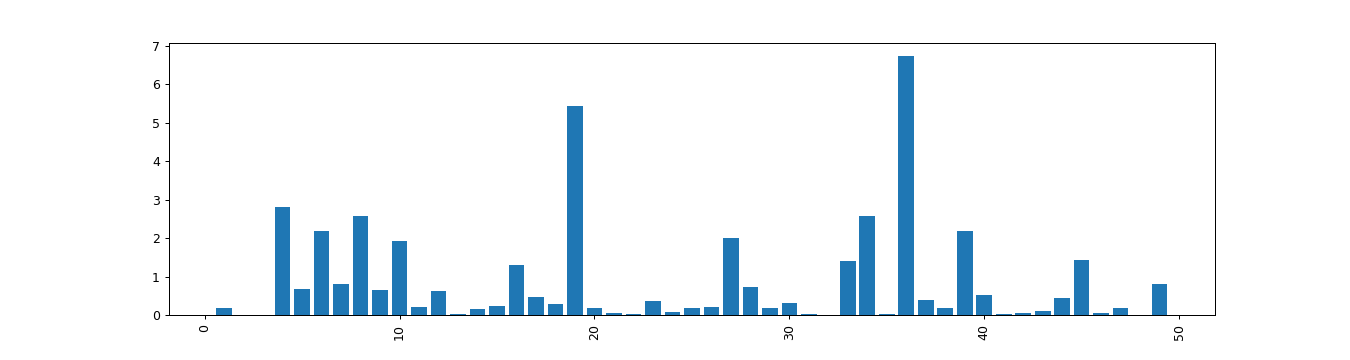

In [83]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.figure(figsize=(15, 4))
plt.bar(list(range(0,len(stack[0].loc[0,:]))), fs.scores_)
plt.xticks(rotation=90)
pyplot.show()

<IPython.core.display.Javascript object>


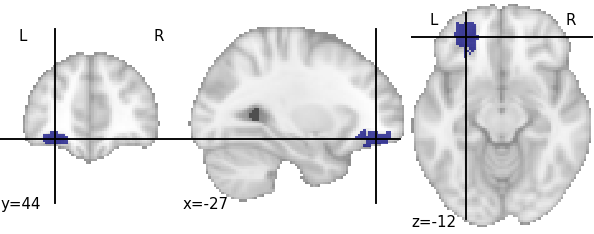

In [85]:
roi_mask = nimg.math_img('a == 36', a=resampled_yeo)  
nplot.plot_roi(roi_mask)

<IPython.core.display.Javascript object>


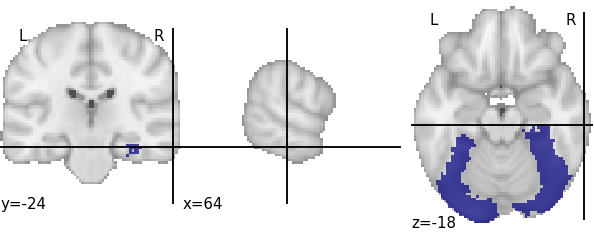

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


In [100]:
roi_mask = nimg.math_img('a == 1', a=resampled_yeo)  
nplot.plot_roi(roi_mask, cut_coords=(64.6, -24.41, -18.57))